In [99]:
import os

from IPython import display
# import tflite_model_maker as mm
# from tflite_model_maker import audio_classifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import librosa
import librosa.display
%matplotlib inline

In [18]:
#Getting yamnet from tf_hub
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [19]:
os.chdir('D:\\Games\\UrbanSound8K\\UrbanSound8K')

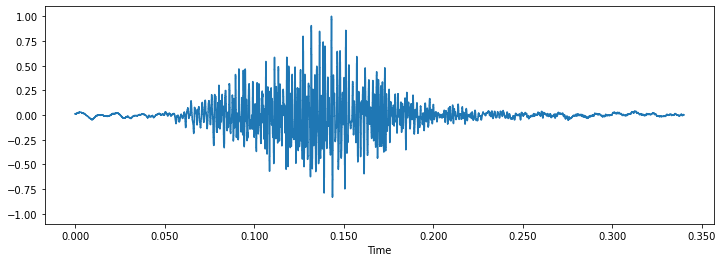

In [22]:
#EDA of the dataset
plt.figure(figsize=(12,4))
filename = './dog.wav'
data,sampling_rate = librosa.load(filename)
librosa.display.waveshow(data,sr=sampling_rate)
# display.Audio(filename)

In [25]:
metadata_df = pd.read_csv('metadata//UrbanSound8K.csv')
metadata_df.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [27]:
###Check balance
metadata_df['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [78]:
#Converting audio signal to mel-frequency coordinate for classification
def feature_extractor(filename):
    data,sampling_rate = librosa.load(filename,res_type='kaiser_fast')
    # print(data,sampling_rate)
    mfcc_data = librosa.feature.mfcc(y=data,sr=sampling_rate)    
    # print(mfcc_data)
    mfcc_mean = np.mean(mfcc_data.T,axis=0)
    return mfcc_mean

In [79]:
extracted_features = []
audio_path = 'audio'
for index,row in metadata_df.iterrows():
    # fold_number = 'fold'+str(row['fold'])
    # filename = str(row['slice_file_name'])
    # file = 'audio/{fold_number}/{filename}'
    fileName = os.path.join(os.path.abspath(audio_path),'fold'+str(row['fold'])+'\\',str(row['slice_file_name']))
    # print(fileName)
    class_label = row['class']
    data = feature_extractor(fileName)
    extracted_features.append([data,class_label])
    # print(len(row))
    # break


c:\Users\17164\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
c:\Users\17164\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
c:\Users\17164\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [80]:
extracted_features_df = pd.DataFrame(extracted_features,columns=['mel_freq_array','class'])
extracted_features_df

,mel_freq_array,class
0,"[-218.18938, 71.38549, -131.49442, -52.25892, ...",dog_bark
1,"[-425.05234, 110.67095, -54.192833, 62.045414,...",children_playing
2,"[-459.82623, 122.82864, -47.908062, 53.302677,...",children_playing
3,"[-414.82184, 102.94826, -36.65685, 54.170742, ...",children_playing
4,"[-447.60776, 115.08627, -53.74607, 61.55309, 1...",children_playing
...,...,...
8727,"[-399.52393, 136.84413, -51.977036, 37.014854,...",car_horn
8728,"[-347.3277, 87.53586, -46.2994, 52.748062, -33...",car_horn
8729,"[-304.84702, 112.69567, -47.21992, 37.061134, ...",car_horn
8730,"[-345.06885, 126.78658, -56.18254, 36.07703, -...",car_horn


In [88]:
X = np.array(extracted_features_df['mel_freq_array'].tolist())
y = np.array(extracted_features_df['class'].tolist())
y_encoded = np.array(pd.get_dummies(y))
y_encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [96]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [93]:
# my_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
#                           name='input_embedding'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(10)
# ], name='my_model')


2.8.0


In [ ]:
model = Sequential()
inputs = tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding')
model.add(inputs)
